<a href="https://colab.research.google.com/github/A-Wierda/DoloresRiver_Extraction/blob/main/Capstone_NAIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: Code *not* run & reason

1. DEM files because I did not use the ArcGIS streamline to caluculate sinuousity in my final analysis.
2. Maps to draw the 2 geometries (dolores_buffered and dolores_river_geo) You only need to run this code once to draw a line and I don't want to redraw my geometries.
3. Sinuousity calculations

In [ ]:
!pip install geemap==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.6 MB/s eta 0:00:00
  Created wheel for ee-extra: filename=ee_extra-0.0.15-py3-none-any.whl size=236752 sha256=df6ec6236193660baf152be1b348b2bf2396f1649abc36a0ca8ea0f104fc9d51
  Stored in directory: /root/.cache/pip/wheels/04/f2/5f/1ab40801f6334408e009cf01dca51b0359f3356329ee0b464b
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=ec17a130231fefb4ab4c7afe4370925598ec6bb2b06c2b457d44962ca6d83d8c
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Succes

In [ ]:
import geemap #Google earth explorer
import ee #earth explorer
import ee.batch #this allows us to export DEM data

In [ ]:
ee.Authenticate() #I have a real ee account
ee.Initialize(project='ee-ajwierda3') #my project in Google Cloud

### Workflow

Geometries
1. Download DEM data from GEE for export into ArcGIS to caluclate sinuosity
2. Draw and export general Dolores streamline geojson to buffer to clip NAIP imagery (dolores_buffered)
3. Draw and export a smaller Dolores geometry geojson to clip to classified imagery to exclude holding ponds and shadows (dolores_river_geo)

River Extraction
1.NAIP: Aug. 2021-used for test/train models
2. Method 1: Remove shadows, NDWI, NLCD mask
3. Method 2: NIR mask (#2)
4. Method 3: Random Forest Classification (#1)
5. Method 4: SVM Classification
6. Visual analysis using widgets & accurracy rating, classifcation reports, and confusion matrix

Statistical Analysis of Dolores River
1. Sinuosity
2. Water Pixel count

Analysis Per Year
1. Load Imagery
2. Extract river
3. Count pixels

## Geometries

### Download DEM data from GEE for export into ArcGIS to caluclate sinuosity

In [ ]:
#get county boundaries and our aoi
colorado_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '08'))
utah_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '49'))

# Filter for Dolores (FIPS code '033') and Montezuma (FIPS '083')
dolores = colorado_counties.filter(ee.Filter.eq('COUNTYFP', '033'))
montezuma = colorado_counties.filter(ee.Filter.eq('COUNTYFP', '083'))
mesa = colorado_counties.filter(ee.Filter.eq('COUNTYFP', '077'))
san_miguel = colorado_counties.filter(ee.Filter.eq('COUNTYFP', '113'))
montrose = colorado_counties.filter(ee.Filter.eq('COUNTYFP', '085'))
grand_county = utah_counties.filter(ee.Filter.eq('COUNTYFP', '019'))

# Combine all counties into one geometry
aoi = dolores.merge(montezuma).merge(mesa).merge(san_miguel).merge(grand_county).merge(montrose)

#get DEM (digital elevation model) data at 1m resolution for those counties, year 2018
#mosaic to put them all into one image
dem = ee.ImageCollection('USGS/3DEP/1m').mosaic()

clipped_dem = dem.clip(aoi);

#double check that it all looks good on the map
m = geemap.Map(center=[37.578517, -108.225418], zoom=12)
m.addLayer(clipped_dem, {'min': 1000, 'max': 3000, 'palette': ['blue', 'green', 'brown']}, 'DEM')
m.addLayer(aoi, {}, 'County Boundaries')
m

Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
#Let's export that to my Drive as a geotiff to get it into ArcGIS
task = ee.batch.Export.image.toDrive(
    image=clipped_dem,
    description='dolores_river_counties_dem',
    folder='GEE',
    scale=30,
    region=aoi.geometry(),
    fileFormat='GeoTIFF',
    maxPixels= 1e13
)
task.start()

In [ ]:
import time
while task.active():
    print('Exporting... please wait.')
    time.sleep(500)
print('Export complete!')

Exporting... please wait.


KeyboardInterrupt: 

In ArcGIS, I selected line features for the upper and lower Dolores and exported shapefiles for both the upper and lower Dolores.

Upload upper and lower shapefiles

In [ ]:
!pip install pycrs

In [ ]:
import pycrs
#upload shapefiles of river line for both upper and lower Dolores
upper_dolores = geemap.shp_to_ee('/content/Steamline_Upper Dolores.shp')
lower_dolores = geemap.shp_to_ee('/content/Streamline_Lower Dolores.shp')

In the analysis section, I was able to use the shapefiles to calculate the sinuousity of the upper and lower Dolores.

Result: lower Dolores is more sinuous (probably due to the canyons it flows through).

### Draw and export general Dolores streamline geojson to buffer to clip NAIP imagery

The shapefile from ArcGIS is too complex to buffer

dolores_buffered

In [ ]:
# 1. Create an interactive map and draw the Dolores
m = geemap.Map(center=(37.578517, -108.225418), zoom=10)

# Add drawing controls to allow user to draw a river
m.addLayerControl()  # Allows turning layers on/off
m.add_basemap('SATELLITE')  # NAIP-like satellite imagery
m.add_draw_control()  # Adds a drawing tool for users

# Display the map
m

Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
# 2.export it to gejson using last drawn feature

# Retrieve the last drawn feature
feature = m.draw_last_feature

if feature is not None:
    # Convert the feature to a FeatureCollection
    feature_collection = ee.FeatureCollection([feature])

    # Define the output file path
    out_file = 'drawn_feature.geojson'

    # Export the FeatureCollection to a GeoJSON file
    geemap.ee_export_vector(feature_collection, filename=out_file)
    print(f"Feature exported to {out_file}")
else:
    print("No feature drawn.")

In [ ]:
# 3.import geojson

# Define the path to your GeoJSON file
geojson_file = '/content/drawn_feature.geojson'

# Convert the GeoJSON file to an Earth Engine FeatureCollection
dolores_river_fc = geemap.geojson_to_ee(geojson_file)

# Verify the FeatureCollection via coordinates
print(dolores_river_fc.getInfo())

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'LineString', 'coordinates': [[-107.900122, 37.728502], [-107.906648, 37.730675], [-107.909395, 37.73434], [-107.910597, 37.738413], [-107.911628, 37.743571], [-107.913516, 37.748865], [-107.912143, 37.750765], [-107.91489, 37.755787], [-107.917981, 37.76298], [-107.923648, 37.768272], [-107.9288, 37.770986], [-107.936871, 37.778177], [-107.945113, 37.779399], [-107.956619, 37.779263], [-107.967953, 37.773836], [-107.976882, 37.7718], [-107.981175, 37.771122], [-107.989075, 37.768679], [-108.004186, 37.756873], [-108.013116, 37.749001], [-108.020672, 37.739092], [-108.028898, 37.732575], [-108.030959, 37.720356], [-108.032505, 37.707726], [-108.030616, 37.697812], [-108.034909, 37.693873], [-108.034565, 37.686401], [-108.035939, 37.679201], [-108.038171, 37.674854], [-108.037465, 37.666837], [-108.041586, 37.657596], [-108.048799, 37.650665], [-1

In [ ]:
# 4. Buffer the line geometry of the Dolores River

buffer_size = 500  #this is in meters ;)
dolores_buffered = dolores_river_fc.map(lambda feature: feature.buffer(buffer_size)) #check out that cool in-line lambda function!

# Verify via info
print(dolores_buffered.getInfo())

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-107.90232944944198, 37.72435513250864], [-107.90077721181702, 37.7240325112914], [-107.89917282852248, 37.72406564047127], [-107.89764398606161, 37.72445188342849], [-107.89631236201042, 37.725160500367316], [-107.89528394518736, 37.726135093599005], [-107.89464060158254, 37.72729809423342], [-107.89443355657475, 37.7285569339383], [-107.89467931264103, 37.72981141134422], [-107.89535832899004, 37.730961667364326], [-107.89641657033282, 37.7319161348151], [-107.89776980359237, 37.73259882928745], [-107.89791430332677, 37.73264882632573], [-107.90271087491915, 37.734246031858724], [-107.90405372632401, 37.736037779690584], [-107.90500930052275, 37.73927655929234], [-107.90600770487836, 37.74427337323188], [-107.90608356768053, 37.74446850619015], [-107.90611076103231, 37.744671516307946], [-107.90615145694254, 37.744792033316195], [-107

### Draw and export a smaller Dolores geometry geojson to clip to classified imagery to exclude holding ponds and shadows

dolores_river_geo

In [ ]:
# 1. Create an interactive map
#try to draw shape close to river to exclude shadows

m = geemap.Map(center=(37.578517, -108.225418), zoom=10)

# Add drawing controls to allow user to draw a river
m.addLayerControl()  # Allows turning layers on/off
m.add_basemap('SATELLITE')  # NAIP-like satellite imagery
m.add_draw_control()  # Adds a drawing tool for users

# Display the map
m


Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
# 2. Retrieve the last drawn feature and export it
feature = m.draw_last_feature

if feature is not None:
    # Convert the feature to a FeatureCollection
    feature_collection = ee.FeatureCollection([feature])

    # Define the output file path
    out_file = 'river_clipped.geojson'

    # Export the FeatureCollection to a GeoJSON file
    geemap.ee_export_vector(feature_collection, filename=out_file)
    print(f"Feature exported to {out_file}")
else:
    print("No feature drawn.")

In [ ]:
# 3.import geojson

# Define the path to your GeoJSON file
geojson_file = '/content/river_clipped.geojson'

# Convert the GeoJSON file to an Earth Engine FeatureCollection
dolores_river_geo = geemap.geojson_to_ee(geojson_file)

# Verify the FeatureCollection via coordinates
print(dolores_river_geo.getInfo())

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-108.520157, 37.467637], [-108.516938, 37.467808], [-108.51565, 37.468727], [-108.514791, 37.469409], [-108.51389, 37.469068], [-108.511743, 37.468148], [-108.509854, 37.468148], [-108.508137, 37.469477], [-108.506334, 37.470533], [-108.503801, 37.471043], [-108.501526, 37.471554], [-108.500452, 37.471895], [-108.498735, 37.471691], [-108.496631, 37.473155], [-108.495558, 37.474007], [-108.493755, 37.474211], [-108.491995, 37.47387], [-108.489591, 37.474415], [-108.486371, 37.474517], [-108.484879, 37.47496], [-108.481402, 37.474245], [-108.47698, 37.474994], [-108.463586, 37.472474], [-108.458434, 37.474109], [-108.453626, 37.4737], [-108.452681, 37.473496], [-108.451265, 37.472951], [-108.450406, 37.473462], [-108.449897, 37.474381], [-108.447794, 37.47496], [-108.445819, 37.474449], [-108.443329, 37.472746], [-108.

## River Extraction

#### NAIP: Aug. 2021-used for test/train models

In [ ]:
# Load NAIP imagery (0.6-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2021-08-01', '2021-08-30') \
    .median()

# Clip to the buffered area
naip_clipped_21 = naip.clip(dolores_buffered)

#This was to remove shadows, unecessary in final model selection of Random Forest
#naip_rgbn = naip_clipped_21.select('R','G','B','N')

# Verify via image details
print(naip_clipped_21.getInfo())

{'type': 'Image', 'bands': [{'id': 'R', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'G', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'N', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


Naip variables= naip_clipped_last 2 of the year
For example, 2009 = naip_clipped_09
Years: 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023

### Method 1: Remove Shadows with Thresholding & Masking + NDWI + NLCD masking to remove urban

Issues:
1. shadows on the river are eliminated and some of the shadowed parts of the river are not captured.
2. near the town, some of the river is not captured.


In [ ]:
#create a map to visualize the process as it happens
#map centered at the Dolores River
m1 = geemap.Map(center=[37.578517, -108.225418], zoom=12)
m1.addLayer(naip_clipped_21, {"bands": ["R", "G", "B"], "min": 0, "max": 255}, "NAIP Imagery 2021")
m1


Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

Remove shadows using RGB bands

In [ ]:
#Create grayscale
#Select RGB bands
rgb = naip_clipped_21.select(['R', 'G', 'B'])

# Calculate average of RGB bands
grayscale = rgb.reduce(ee.Reducer.mean()).rename('grayscale')

# Create a new image with the grayscale band
naip_grayscale = naip.addBands(grayscale)


In [ ]:
#remove shadows with mask
# Set a threshold for shadow detection (adjust this value)
shadow_threshold = 50

# Create a shadow mask (pixels below the threshold are shadows)
shadow_mask = naip_grayscale.select('grayscale').lt(shadow_threshold)

# Mask the original NAIP image using the shadow mask
naip_no_shadows = naip.updateMask(shadow_mask.Not())

# Visualize the result (see above)
m1.addLayer(naip_no_shadows, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, 'NAIP No Shadows')

Compute the Normalized Difference Water Index

In [ ]:
# Compute NDWI (Normalized Difference Water Index)
ndwi = naip_no_shadows.normalizedDifference(["G", "N"]).rename("NDWI")

# Create a binary mask for water (NDWI > 0.1 =>1= True, means its water; NDWI < 0.1 =>0= False)
water_mask = ndwi.gt(0.1)

# Print mask details
print(water_mask.getInfo())

#add to map
m1.addLayer(water_mask.selfMask(), {"palette": "blue"}, "Water Mask")

{'type': 'Image', 'bands': [{'id': 'NDWI', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


Create a NLCD mask to exclude town of Dolores because the NDWI was not able to exclude it.

In [ ]:
#Create NLCD mask to exclude: snow, pasture/hay, cultivated crops, developed of any type

# Load NLCD land cover (2019)
nlcd = ee.Image("USGS/NLCD_RELEASES/2019_REL/NLCD/2019").select("landcover")

# Define classes to exclude: snow, pasture/hay, cultivated crops, developed of any type
excluded_classes = nlcd.eq(12).Or(nlcd.eq(21)).Or(nlcd.eq(22)).Or(nlcd.eq(23)).Or(nlcd.eq(24)).Or(nlcd.eq(81)).Or(nlcd.eq(82))

# Create the mask: Keep everything EXCEPT the excluded classes
clean_ndwi = ndwi.updateMask(excluded_classes.Not())

#add the ndwi and the nlcd mask
m1.add_layer(clean_ndwi.selfMask(), {"palette": "blue"}, "Water + NLCD Mask")

### Method 2: Use NIR Band water mask & use smaller Dolores River geo (2nd place)


Issues:

1. there are still big shadows (removing as them as in Method 1 takes away too much of the river).
2. Lots of noise

In [ ]:
# 1. create a map to visualize the process as it happens
#map centered at the Dolores River
m2 = geemap.Map(center=[37.578517, -108.225418], zoom=12)
m2.addLayer(naip_clipped_21, {"bands": ["R", "G", "B"], "min": 0, "max": 255}, "NAIP Imagery 2021")
m2

Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
#2. Create grayscale
#Select RGB bands
rgb = naip_clipped_21.select(['R', 'G', 'B'])

# Calculate average of RGB bands
grayscale = rgb.reduce(ee.Reducer.mean()).rename('grayscale')

# Create a new image with the grayscale band
naip_grayscale = naip.addBands(grayscale)

# 3. remove shadows with mask
# Set a threshold for shadow detection (adjust this value)
shadow_threshold = 50

# Create a shadow mask (pixels below the threshold are shadows)
shadow_mask = naip_grayscale.select('grayscale').lt(shadow_threshold)

# Mask the original NAIP image using the shadow mask
naip_no_shadows = naip.updateMask(shadow_mask.Not())

# Visualize the results of naip without shadows (see above)
m2.addLayer(naip_no_shadows, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, 'NAIP No Shadows')

In [ ]:
# 3. Create water mask, apply it to naip without shadows and naip with shadows, and visualize on map
# Compare and contrast via visual inspection
# With shadows for the win!!

#threshold for water at 40 based on trial and error/histogram below

# Naip w/ shadows-create mask for NIR band
naip_shadows_nir = naip_clipped_21.select('N')
water_mask_shadow = naip_shadows_nir.lt(40)
river_shadows = naip_shadows_nir.updateMask(water_mask_shadow)

#clip to narrow geometry of Dolores River
river_shadows = river_shadows.clipToCollection(dolores_river_geo)

m2.addLayer(river_shadows, {'bands':['N'], 'min':0, 'max':255, 'palette':['blue', 'white']}, "Dolores River w/ Shadows")

Use a histogram to get an idea of the best threshold value for NIR band

In [ ]:
histogram = naip_shadows_nir.reduceRegion(
    reducer=ee.Reducer.histogram(255),
    geometry=dolores_buffered.geometry(),
    scale=1,
    maxPixels=1e11
).get('N').getInfo()


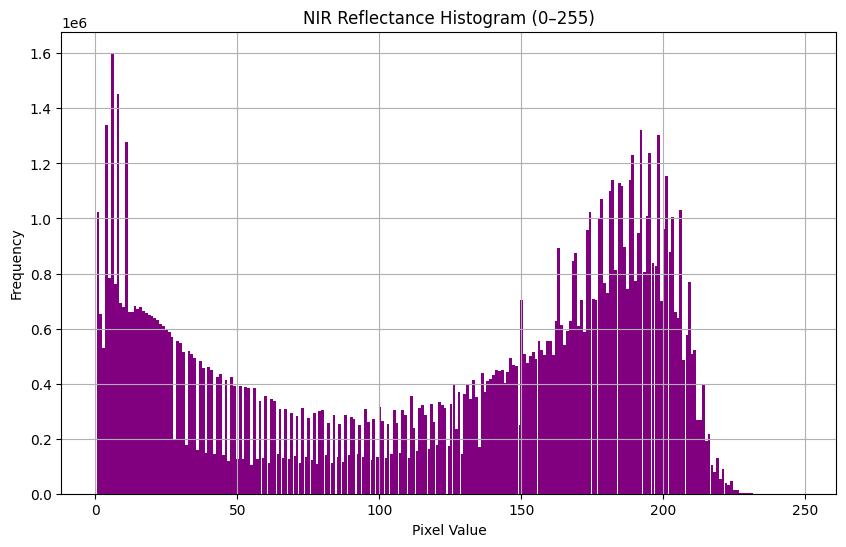

In [ ]:
import matplotlib.pyplot as plt
# Extract histogram data
hist_values = histogram['histogram']
hist_bins = histogram['bucketMeans']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(hist_bins, hist_values, width=1.0, color='purple')
plt.title('NIR Reflectance Histogram (0–255)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Method 3: Machine Learning: Random Forest + object based removel to clear noise (1st Place)

Best model 95% accuracy

In [ ]:
# 1. Create a map to visualize process
m3 = geemap.Map(center=[37.578517, -108.225418], zoom=12)
m3.addLayer(naip_clipped_21, {"bands": ["R", "G", "B"], "min": 0, "max": 255}, "NAIP Imagery 2021")
m3

Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

#### Visualize trained model, clip, & remove noise

In [ ]:
# 1. Train the Random Forest Model using created training points from NAIP 2021 imagry

#get training points (just the lat/long and class) from my GEE assets
training_points = ee.data.getAsset("users/ajwierda3/NAIP_Dolores_training_points")

# Convert the table asset to a FeatureCollection
training_points = ee.FeatureCollection(training_points['id'])

#Make the sample training data to connect the NAIP bands to the class (0=land, 1=water)
bands = ['R', 'G', 'B', 'N']

samples = naip_clipped_21.select(bands).sampleRegions(
    collection=training_points,
    properties=['class'],  # 0 = land, 1 = water
    scale=1
)

#Here's the action: let's train our classifier to predict the class based on the bands of the sample training data
classifier = ee.Classifier.smileRandomForest(50).train(
    features=samples,
    classProperty='class',
    inputProperties=bands
)


In [ ]:
# 2. Classify  and clip NAIP 2021 to smaller Dolores geometry
classified = naip_clipped_21.select(bands).classify(classifier)
#classified.getInfo()

#clip the classified naip to the Dolores River geometry.
classified_naip_21 = classified.clip(dolores_river_geo)

In [ ]:
# 3. object based removal to remove noise

#Find the connected pixels of the same classification (up, down, left, and right)
connected = classified_naip_21.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

# Get the pixel count for each connected component
water_sizes = connected.select('labels').connectedPixelCount(128, True)

# Keep only objects with more than 10 pixels
dolores_river = classified_naip_21.updateMask(water_sizes.gte(10))

#put it on the map-that liquid gold of water
m3.addLayer(dolores_river.selfMask(), {"palette": "blue"}, "Dolores River")

#### Evaluate Model using accuracy, classifcation report, and confusion matrix

It passed the visual inspection, now let's dive deeper.

In [ ]:
#1. Prepare and process training points

#get training points (just the lat/long and class) from my GEE assets
training_points = ee.data.getAsset("users/ajwierda3/NAIP_Dolores_training_points")

# Convert the table asset to a FeatureCollection
training_points = ee.FeatureCollection(training_points['id'])

bands = ['R', 'G', 'B', 'N']

#the training geometry points are added to 'samples' that includes the NAIP bands, the class (0=land, 1=water), and the geometries
samples = naip_clipped_21.select(bands).sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=1
)
#'id' is the index, has the DN of each band and its 'class' (0,land and 1,water)
#samples.getInfo()

# create test/train (70/30)
training_points = samples.randomColumn('random')
training_fc = training_points.filter(ee.Filter.lt('random', 0.7))
testing_fc = training_points.filter(ee.Filter.gte('random', 0.7))


In [ ]:
# 3. Train classifier with training points & test classifier with testing points

# train classifier with training points
classifier = ee.Classifier.smileRandomForest(50).train(
    features=training_fc,
    classProperty='class',
    inputProperties=bands
)

# test it with testing points
classified_test = testing_fc.classify(classifier)

# 'classification' is a new column that has the class according to the classifier
#classified_test.getInfo()

In [ ]:
# 4. Evaluate the model

# split the testing data it the 'class' (the actual value) and 'classification' (the value predicted by the classifier)
# Get class values as a list
y_test = classified_test.aggregate_array('class').getInfo()
y_pred = classified_test.aggregate_array('classification').getInfo()

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ClassificationReport:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9527410207939508
ClassificationReport:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       247
           1       0.97      0.94      0.95       282

    accuracy                           0.95       529
   macro avg       0.95      0.95      0.95       529
weighted avg       0.95      0.95      0.95       529

Confusion Matrix:
 [[239   8]
 [ 17 265]]


### Method 4: Machine Learning Support Vector Machine (SVM)

94% accuracy

In [ ]:
# 1. Create a map to visualize process
m4 = geemap.Map(center=[37.578517, -108.225418], zoom=12)
m4.addLayer(naip_clipped_21, {"bands": ["R", "G", "B"], "min": 0, "max": 255}, "NAIP Imagery 2021")
m4

Map(center=[37.578517, -108.225418], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

#### Visual trained model, clip, and remove noise

In [ ]:
# 2. Train the SVM Model using created training points from NAIP 2021 imagry

#get training points (just the lat/long and class) from my GEE assets
training_points = ee.data.getAsset("users/ajwierda3/NAIP_Dolores_training_points")

# Convert the table asset to a FeatureCollection
training_points = ee.FeatureCollection(training_points['id'])

#Make the sample training data to connect the NAIP bands to the class (0=land, 1=water)
bands = ['R', 'G', 'B', 'N']

samples = naip_clipped_21.select(bands).sampleRegions(
    collection=training_points,
    properties=['class'],  # 0 = land, 1 = water
    scale=1
)

#Here's the action: let's train our classifier to predict the class based on the bands of the sample training data
classifier = ee.Classifier.libsvm().train(
    features=samples,
    classProperty='class',
    inputProperties=bands
)

# 2. Classify  and clip NAIP 2021 to smaller Dolores geometry
classified = naip_clipped_21.select(bands).classify(classifier)
#classified.getInfo()

#clip the classified naip to the Dolores River geometry.
classified_naip_21 = classified.clip(dolores_river_geo)

# 3. object based removal to remove noise

#Find the connected pixels of the same classification (up, down, left, and right)
connected = classified_naip_21.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

# Get the pixel count for each connected component
water_sizes = connected.select('labels').connectedPixelCount(128, True)

# Keep only objects with more than 10 pixels
dolores_river = classified_naip_21.updateMask(water_sizes.gte(10))

#put it on the map-that liquid gold of water
m4.addLayer(dolores_river.selfMask(), {"palette": "blue"}, "Dolores River")


#### Evaluate the model using confusion matrix, accuracy, and classifcation results

In [ ]:
training_points = ee.data.getAsset("users/ajwierda3/NAIP_Dolores_training_points")

# Convert the table asset to a FeatureCollection
training_points = ee.FeatureCollection(training_points['id'])

bands = ['R', 'G', 'B', 'N']  # NAIP bands

#the training geometry points are added to 'samples' that includes the NAIP bands, the class (0=land, 1=water), and the geometries
samples = naip_clipped_21.select(bands).sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=1
)

#'id' is the index, has the DN of each band and its 'class' (0,land and 1,water)
#samples.getInfo()

#create test/train
training_points = samples.randomColumn('random')
training_fc = training_points.filter(ee.Filter.lt('random', 0.7))
testing_fc = training_points.filter(ee.Filter.gte('random', 0.7))

#train the classifier with training_points
classifier = ee.Classifier.libsvm().train(
    features=training_fc,
    classProperty='class',
    inputProperties=bands
)

# Classify the testing set
classified_test = testing_fc.classify(classifier)

#separate into 'class' (acutal class) and 'classification' (predicted class)
y_test = classified_test.aggregate_array('class').getInfo()
y_pred = classified_test.aggregate_array('classification').getInfo()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ClassificationReport:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.943289224952741
ClassificationReport:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       247
           1       0.96      0.93      0.95       282

    accuracy                           0.94       529
   macro avg       0.94      0.94      0.94       529
weighted avg       0.94      0.94      0.94       529

Confusion Matrix:
 [[237  10]
 [ 20 262]]


### Visual Comparision of methods using widgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display


In [ ]:
#create widget with the NAIP maps
#simply change the left/right map widget for the 2 to compare
left_map_widget = m2
right_map_widget = m3

maps_container = widgets.HBox([left_map_widget, right_map_widget])
display(maps_container)

## Statistical Analysis of Dolores River

### River sinuousity

In [ ]:
def sinuosity(feature):
  line_feature = feature.first()
  #Make it a geometry (ie a line)
  line_geometry = line_feature.geometry()

  #Find the distance between the start and end of the line
  # Convert line geometry to a list of coordinates
  coords = line_geometry.coordinates()

  # Get the first and last coordinates
  start = ee.Geometry.Point(coords.get(0))
  end = ee.Geometry.Point(coords.get(coords.length().subtract(1)))

  #distance in meters
  distance = start.distance(end)

  #Find the actual length of the river line with maxError of 1m
  actual_length = line_geometry.length(maxError=1)

  #Find the sinuosity
  sinuosity = ee.Number(actual_length).divide(distance)

  return sinuosity


In [ ]:
sinuosity_upper = sinuosity(upper_dolores)
print('Upper Dolores sinuosity', sinuosity_upper.getInfo())

sinuosity_lower = sinuosity(lower_dolores)
print('Lower Dolores sinuosity', sinuosity_lower.getInfo())

Upper Dolores sinuosity 1.378362286069232
Lower Dolores sinuosity 1.6816308481151083


### Number of Water Pixels

In [ ]:
# Count pixels using the image of the extracted river, the geometry, and the scale of 1 m per pixel for NAIP imagery
pixel_count = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

# Print result
print('Water pixel count:', pixel_count.getInfo())

Water pixel count: {'classification': 196068.9960784314}


## Analysis Per Year

#### NAIP: June-July 2009 (1 m resolution)

In [ ]:
# Load NAIP imagery (1-meter resolution)

naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2009-06-01', '2009-07-30') \
    .median()

# Clip to the buffered area
naip_clipped_09 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_09.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river= classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_09 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_09.get('classification')
sqkm_09 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_09.getInfo())


Water square km: 0.135


#### NAIP: July-Sept. 2011 (1 m resolution)

In [ ]:
# Load NAIP imagery (1-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2011-07-01', '2011-08-30') \
    .median()

# Clip to the buffered area
naip_clipped_11 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_11.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_11 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_11.get('classification')
sqkm_11 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_11.getInfo())

Water square km: 155.14913333333334


#### NAIP: Sept.-Oct. 2013 (1 m resolution)

In [ ]:
# Load NAIP imagery (1-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2013-09-01', '2013-10-30') \
    .median()

# Clip to the buffered area
naip_clipped_13 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_13.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_13 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_13.get('classification')
sqkm_13 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_13.getInfo())

Water square km: 560.9710313725491


#### NAIP: Aug.-Sept. 2015 (1 m resolution)

In [ ]:
# Load NAIP imagery (1-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2015-08-01', '2015-09-30') \
    .median()

# Clip to the buffered area
naip_clipped_15 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_15.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_15 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_15.get('classification')
sqkm_15 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_15.getInfo())

Water square km: 678.0928901960784


#### NAIP: Aug.-Oct. 2017 (1 m resolution)

In [ ]:
# Load NAIP imagery (1-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2017-08-01', '2017-10-30') \
    .median()

# Clip to the buffered area
naip_clipped_17 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_17.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_17 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=1,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_17.get('classification')
sqkm_17 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_17.getInfo())

Water square km: 350.81008235294115


#### NAIP: Aug.-Sept. 2019 (0.6 m resolution)

In [ ]:
# Load NAIP imagery (0.6-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2019-08-01', '2019-09-30') \
    .median()

# Clip to the buffered area
naip_clipped_19 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_19.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_19 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=0.6,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_19.get('classification')
sqkm_19 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_19.getInfo())

Water square km: 1829.7914682352937


#### NAIP: Aug.-Sept. 2021 (0.6 m resolution)

In [ ]:
# Load NAIP imagery (0.6-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2021-08-01', '2021-08-30') \
    .median()

# Clip to the buffered area
naip_clipped_21 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_21.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_21 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=0.6,
    maxPixels=1e9
)

#Convert to square km
water_pixel_count = pixel_count_21.get('classification')
sqkm_21 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_21.getInfo())

Water square km: 5144.700649411766


#### NAIP: Aug.-Sept. 2023 (0.3 m resolution)

In [ ]:
# Load NAIP imagery (0.3-meter resolution)
naip = ee.ImageCollection("USDA/NAIP/DOQQ") \
    .filterBounds(dolores_buffered) \
    .filterDate('2023-08-01', '2023-09-30') \
    .median()

# Clip to the buffered area
naip_clipped_23 = naip.clip(dolores_buffered)

#Extract river

# 1. Random Forest Classifier
classified = naip_clipped_23.select(bands).classify(classifier)

classified_naip = classified.clip(dolores_river_geo)

# 2. Object based removal
connected = classified_naip.connectedComponents(
    connectedness=ee.Kernel.plus(1),
    maxSize=128
)

water_sizes = connected.select('labels').connectedPixelCount(128, True)

dolores_river = classified_naip.updateMask(water_sizes.gte(10))

#Pixel count

pixel_count_23 = dolores_river.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry= dolores_river_geo,
    scale=0.3,
    maxPixels=1e9
)

#Convert to square meter
water_pixel_count = pixel_count_23.get('classification')
sqkm_23 = ee.Number(water_pixel_count).multiply(0.001)

print('Water square km:', sqkm_23.getInfo())

Water square km: 739.3753164705881


### Plot Water Surface Area in Square Meters, adjusted for resolution

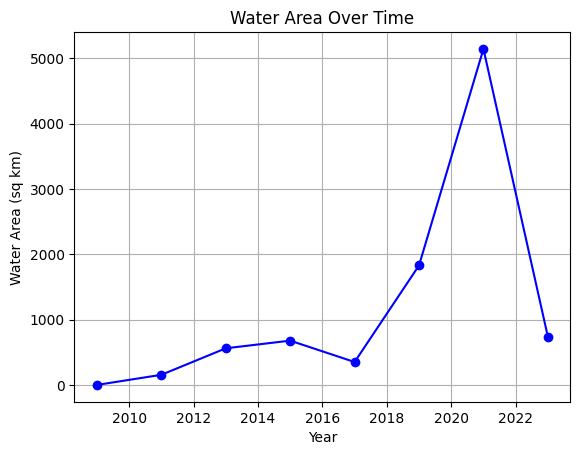

In [ ]:
import matplotlib.pyplot as plt

# Sample data: years and a variable (e.g., water area in sq km)
years = [2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023]
water_area = [sqkm_09.getInfo(), sqkm_11.getInfo(), sqkm_13.getInfo(), sqkm_15.getInfo(), sqkm_17.getInfo(), sqkm_19.getInfo(), sqkm_21.getInfo(), sqkm_23.getInfo()]

# Plot the line graph
plt.plot(years, water_area, marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Water Area (sq km)')
plt.title('Water Area Over Time')
plt.grid(True)

# Show the graph
plt.show()

